# Face Classification

In [ ]:
from fastai.core import *
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_02a import *
from facenet_pytorch import MTCNN
from nbdev.export import *
from IPython.display import HTML

### Data

In [ ]:
ls ../data/train_sample_faces | wc -l

381


In [ ]:
ls ../data

dfdc_train_part_0/  dfdc_train_part_00.zip  train_sample_faces/


In [ ]:
ls ../data/dfdc_train_part_0 | wc -l

1321


In [ ]:
#SOURCE = Path('../data/train_sample_faces/')

In [ ]:
train_sample_metadata = pd.read_json('../../data/dfdc_train_part_0/metadata.json').T
train_sample_metadata.head()

,label,original,split
owxbbpjpch.mp4,FAKE,wynotylpnm.mp4,train
vpmyeepbep.mp4,REAL,NaN,train
fzvpbrzssi.mp4,REAL,NaN,train
htorvhbcae.mp4,FAKE,wclvkepakb.mp4,train
fckxaqjbxk.mp4,FAKE,vpmyeepbep.mp4,train


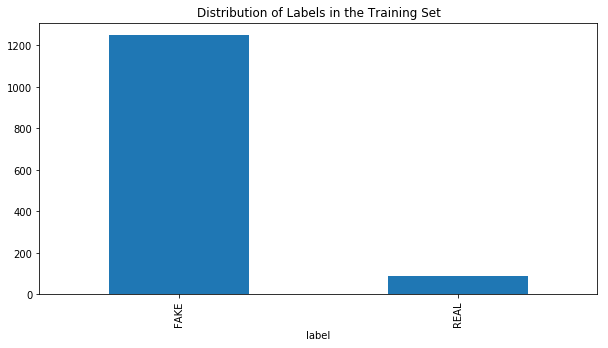

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(10, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [ ]:
(train_sample_metadata['label'] == 'REAL').sum()

86

In [ ]:
(train_sample_metadata['label'] == 'FAKE').sum()

1248

In [ ]:
src = ImageList.from_folder(SOURCE).split_by_rand_pct(0.1, seed=42)

In [ ]:
lab = r'([A-Z]+).png$'

In [ ]:
bs, sz = 32, 128

In [ ]:
def get_data(bs,size):
    data = (src.label_from_re(lab)
           .transform(get_transforms(), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [ ]:
data = get_data(bs, sz)

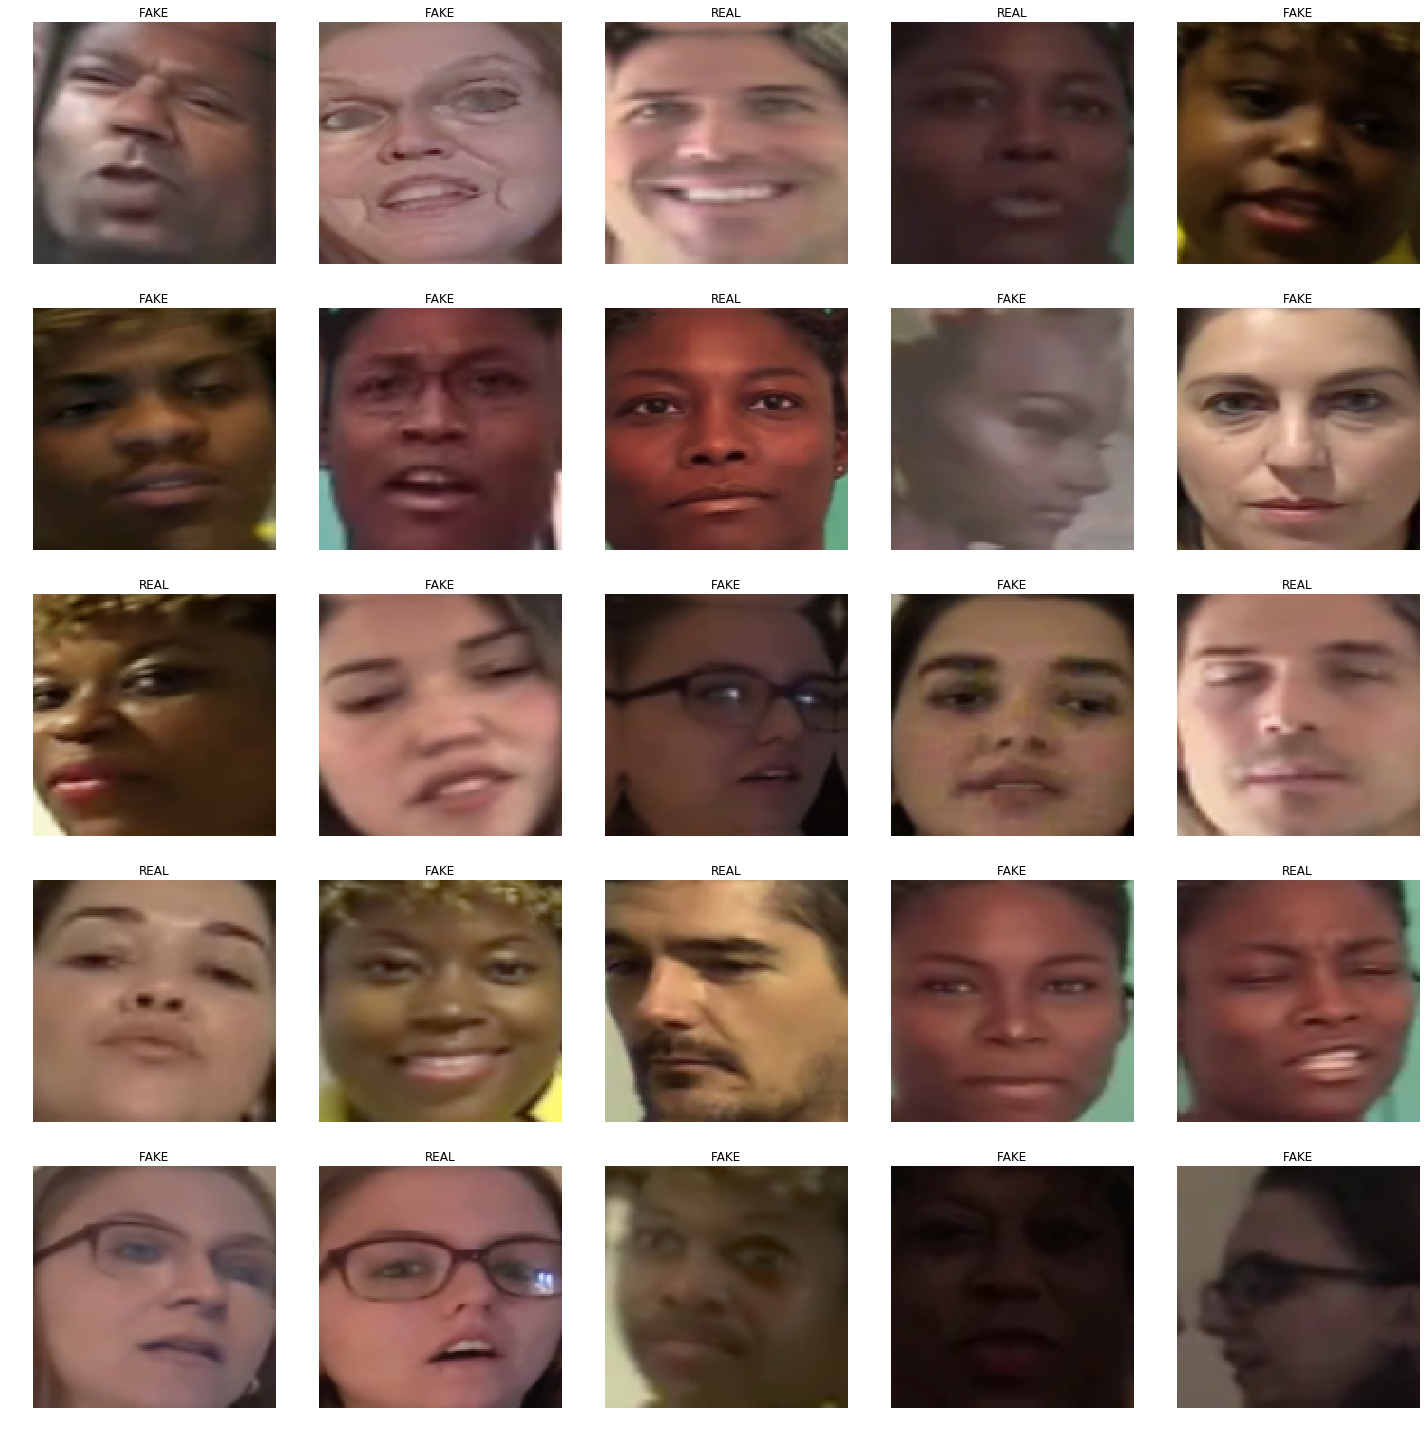

In [ ]:
data.show_batch()

### Model

In [ ]:
# By Nathan Hubens.
# Paper implementation does not use Adaptive Average Pooling. To get the exact same implementation, 
# comment the avg_pool and uncomment the final max_pool layer.
class MesoNet(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.conv1 = nn.Conv2d(3, 8, 3, 1,1) # 8 x 256 x 256
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 5, 1,2) # 8 x 128 x 128
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 5, 1,2) # 8 x 64 x 64
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16,16,5,1,2) # 8 x 32 x 32
        self.bn4 = nn.BatchNorm2d(16)
        self.avg_pool = nn.AdaptiveAvgPool2d((8))
        self.fc1 = nn.Linear(1024, 16)
        self.fc2 = nn.Linear(16, 2)
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))  
        x = self.bn3(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        #x = F.max_pool2d(x, 4, 4)
        
        x = self.avg_pool(x)

        x = x.reshape(x.shape[0], -1)

        x = F.dropout(x, 0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,0.5)
        x = self.fc2(x)
        return x

In [ ]:
learn = Learner(data, models.resnet18(), metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


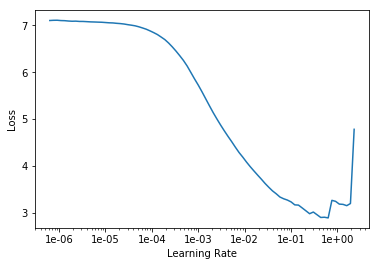

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
epochs, lr = 10, 1e-2

In [ ]:
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,3.440423,2.310279,0.315789,00:01
1,1.888706,67.669800,0.684211,00:01
2,1.338636,16.503239,0.315789,00:01
3,1.064670,6.599325,0.315789,00:01
4,0.904560,0.702398,0.315789,00:01
5,0.803732,0.793019,0.315789,00:01
6,0.731462,0.743085,0.315789,00:01
7,0.673033,0.635540,0.315789,00:01
8,0.631391,0.642196,0.315789,00:01
9,0.597009,0.652042,0.315789,00:01


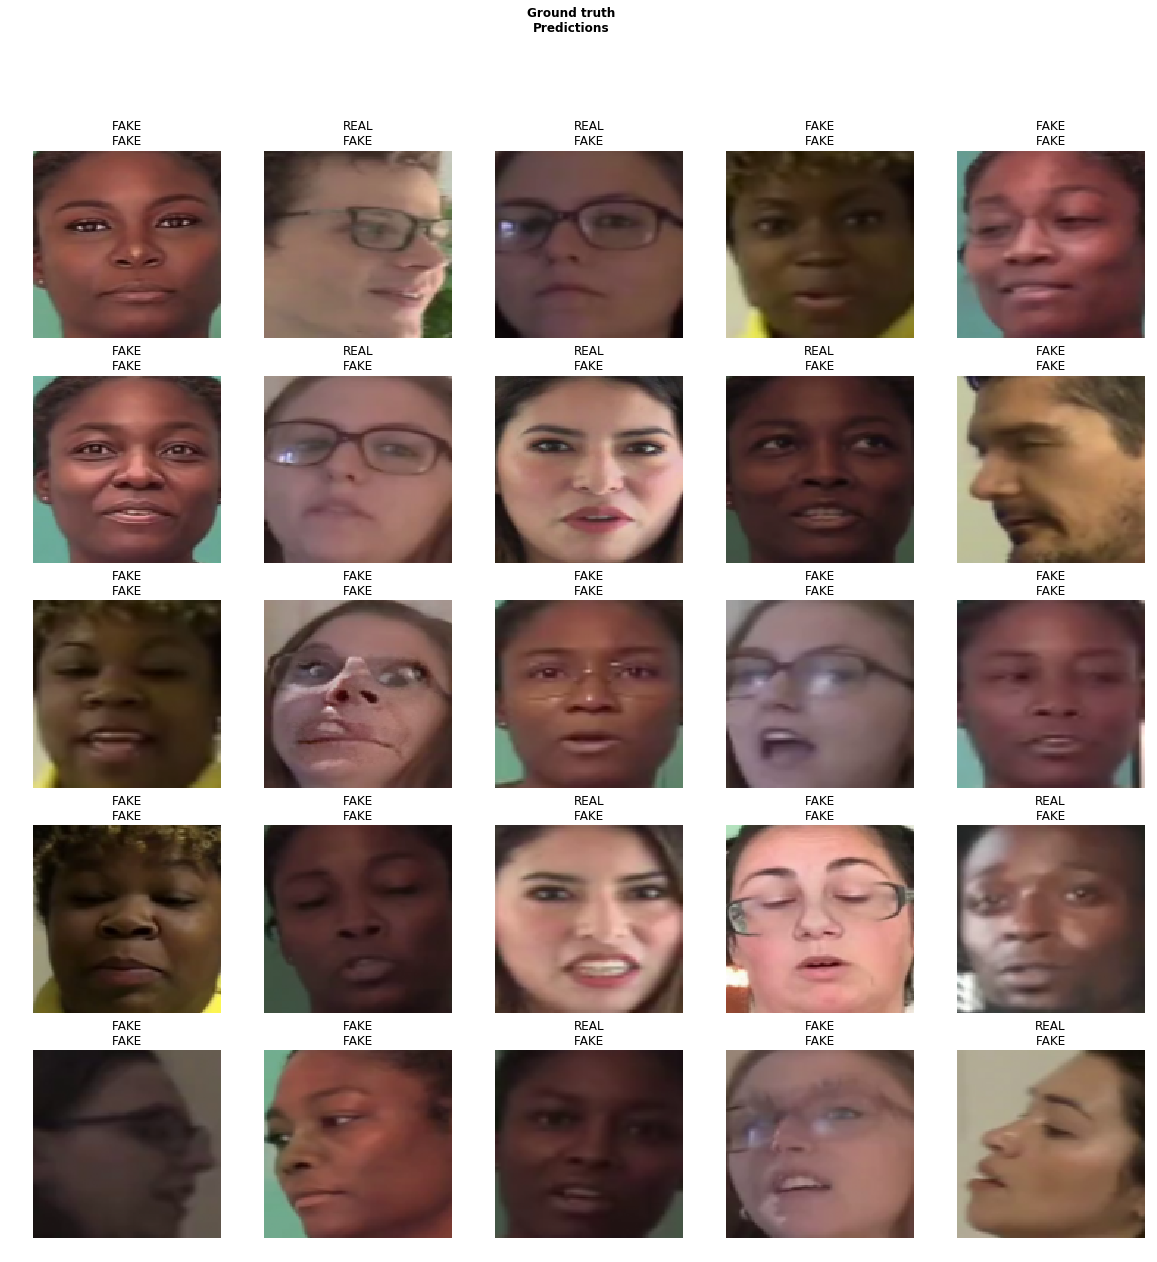

In [ ]:
learn.show_results()